In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
import os
os.chdir("/content/gdrive/MyDrive/Usc/EE641/Project/")
print("current working directory is ", os.getcwd())

current working directory is  /content/gdrive/MyDrive/Usc/EE641/Project


In [ ]:
!pip install yacs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import seg_models as sm
import utils
from utils import HDF5Dataset, training_loop, test_loop

In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available()
                  else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [ ]:
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomRotation((0, 5))])

test_transforms = transforms.Compose([transforms.ToTensor()])

In [ ]:
infect_path = "HDF5Data/infect_data.hdf5"
infect_train_dataset = HDF5Dataset(infect_path, 'train', transform=train_transforms)
infect_val_dataset = HDF5Dataset(infect_path, 'val', transform=test_transforms)
infect_test_dataset = HDF5Dataset(infect_path, 'test', transform=test_transforms)

In [ ]:
n_epochs = 50
batch_size = 64
stop = 20
num_works = 2

infect_Unet_micronet_m0 = sm.Unet(
    encoder_name="micronet_m0",
    in_channels=1,                  
    classes=1,                      
).to(device)

infect_optimizer = optim.Adam(infect_Unet_micronet_m0.parameters(), lr=0.0001)
loss_fcn = utils.DiceBCELoss()

In [ ]:
infect_train_loader = DataLoader(infect_train_dataset, batch_size=batch_size, 
shuffle=True, num_workers=num_works)
infect_val_loader = DataLoader(infect_val_dataset, batch_size=batch_size, 
shuffle=True, num_workers=num_works)

In [ ]:
training_loop(
    infect_Unet_micronet_m0, infect_optimizer,
    loss_fcn, infect_train_loader,
    infect_val_loader, mask_name='infection mask',
    n_epochs=n_epochs, device=device, 
    save_path='trained_models/infect_Unet_micronet_m0.pt',
    stop = stop)

Epoch 1 Training Start:
Epoch 1, Batch 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1, train loss: 1.309
Duration: 0.562 minutes
Epoch 1 Validation Start:
Epoch 1, Batch 0
Epoch 1, val loss: 1.137
Detect Improvement, Save Model
Epoch 2 Training Start:
Epoch 2, Batch 0
Epoch 2, train loss: 1.112
Duration: 0.474 minutes
Epoch 2 Validation Start:
Epoch 2, Batch 0
Epoch 2, val loss: 1.020
Detect Improvement, Save Model
Epoch 3 Training Start:
Epoch 3, Batch 0
Epoch 3, train loss: 1.009
Duration: 0.478 minutes
Epoch 3 Validation Start:
Epoch 3, Batch 0
Epoch 3, val loss: 0.922
Detect Improvement, Save Model
Epoch 4 Training Start:
Epoch 4, Batch 0
Epoch 4, train loss: 0.931
Duration: 0.483 minutes
Epoch 4 Validation Start:
Epoch 4, Batch 0
Epoch 4, val loss: 0.871
Detect Improvement, Save Model
Epoch 5 Training Start:
Epoch 5, Batch 0
Epoch 5, train loss: 0.870
Duration: 0.478 minutes
Epoch 5 Validation Start:
Epoch 5, Batch 0
Epoch 5, val loss: 0.808
Detect Improvement, Save Model
Epoch 6 Training Start:
Epoch 6, Batch 0
Epoch 6, train loss: 0.820
Duration: 0.480 mi

# Test

In [ ]:
infect_test_loader = DataLoader(infect_test_dataset, batch_size=1, num_workers=num_works)

In [ ]:
test_infect_Unet_micronet_m0 = torch.load('trained_models/infect_Unet_micronet_m0.pt')
test_loop(test_infect_Unet_micronet_m0, infect_test_loader, 
mask_name='infection mask', device=device)

accuracy mean: 0.861, accuracy standard deviation: 0.101
IoU mean: 0.000, IoU standard deviation: 0.000
DSC mean: 0.000, DSC standard deviation: 0.000


(0.8610276579856873, 0.10134493559598923, 0.0, 0.0, 0.0, 0.0)

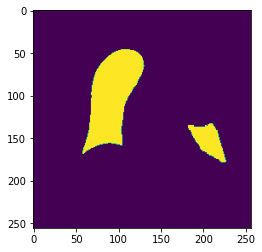

In [ ]:
plt.imshow(infect_test_dataset[0][1])

In [ ]:
infect_test_dataset[0][0].unsqueeze(0).shape

torch.Size([1, 1, 256, 256])

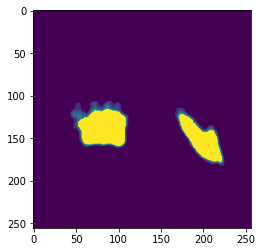

In [ ]:
output = test_infect_Unet_micronet_m0(infect_test_dataset[0][0].unsqueeze(0).to(device))
output = torch.sigmoid(output)
output[output>=0.5] = 1
output[output < 0.1] = 0
plt.imshow(output.cpu().detach().numpy()[0][0])